# Proyecto: Predicción del precio del oro (XAU)
#
Objetivo: crear un notebook reproducible para Colab que haga EDA, prepare features, entrene un modelo de Machine Learning (Gradient Boosting) y un modelo de series temporales (Prophet), compare métricas y genere un forecast a 30 días.

# ✅ ETAPA 1. CARGA DE LIBRERIAS, DATASET Y VISUALIZACIÓN INICIAL

▶  Importación de Librerias para desarrollo de proyecto

In [90]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#-----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression #regresión lineal
#-----------------------------------------------------------------------
# Libreriras para uso de red convolucional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
#-----------------------------------------------------------------------
#Librerias para uso de serie de tiempo básica
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
#-----------------------------------------------------------------------
#Librerias para uso de serie de tiempo mejorada prophet
from prophet import Prophet


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from google.colab import drive


▶ Carga de drive para lectura de dataset

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


▶ Asignación de dataset

In [3]:
FILE_PATH= '/content/drive/MyDrive/polygonus_oro/XAU_1d_data_V2.csv'

▶ Lectura de dataset, validación de ruta y visualización inicial

In [4]:
df = pd.read_csv(FILE_PATH, sep=None, engine='python')
#print('Archivo cargado correctamente ✅')
#print("Columnas detectadas:", df.columns.tolist())
print(df.head())

         Date   Open   High    Low  Close  Volume
0  2004.06.11  384.0  384.8  382.8  384.1     272
1  2004.06.14  384.3  385.8  381.8  382.8    1902
2  2004.06.15  382.8  388.8  381.1  388.6    1951
3  2004.06.16  387.1  389.8  382.6  383.8    2014
4  2004.06.17  383.6  389.3  383.0  387.6    1568


# ✅ ETAPA 2. LIMPIEZA Y VALIDACIONES

▶ Validación de columnas completas

In [5]:
expected = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
for c in expected:
    if c not in df.columns:
        raise ValueError(f"Falta la columna esperada: {c}")

▶ Eliminar espacios en blanco si los hay

In [6]:
df.columns = df.columns.str.strip()

▶ Validación de la existencia de valores nulos

In [7]:
print(df.isnull().sum())

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


▶ Validación de la existencia de filas con al menos un valor nulo

In [8]:
missing_rows = df[df.isnull().any(axis=1)]
print(f"Total de filas con algún valor nulo: {len(missing_rows)}")

Total de filas con algún valor nulo: 0


▶ Validación de valores en cero para columnas númericas

In [9]:
num_cols = df.select_dtypes(include=[np.number]).columns
zero_counts = (df[num_cols] == 0).sum()
print("\n🔢 Verificación de valores en cero:")
print(zero_counts)


🔢 Verificación de valores en cero:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


▶ Validación de rango de fechas y cantidad de registros

In [10]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
print(f"Desde {df['Date'].min().date()} hasta {df['Date'].max().date()}")
print(f"Total de registros: {len(df)}")

Desde 2004-06-11 hasta 2025-07-11
Total de registros: 5382


/tmp/ipython-input-3648275.py:6: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(False, alpha=0.3)


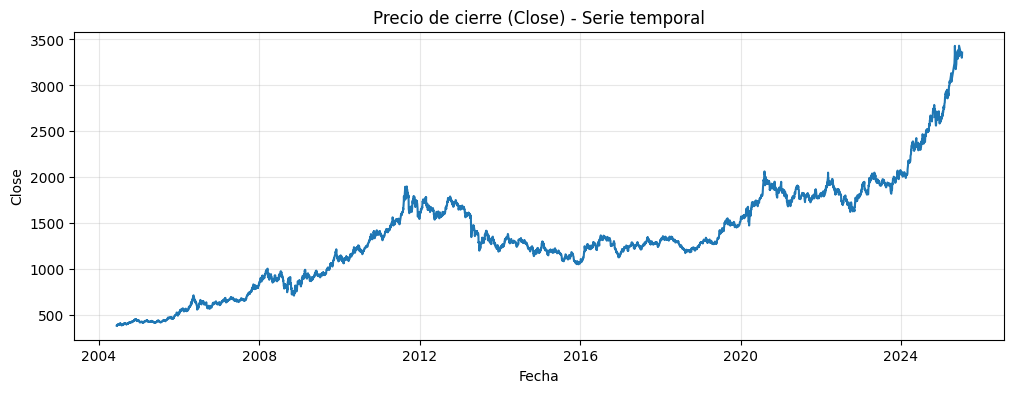

In [11]:
plt.figure(figsize=(12,4))
plt.plot(df['Date'], df['Close'])
plt.title('Precio de cierre (Close) - Serie temporal')
plt.xlabel('Fecha')
plt.ylabel('Close')
plt.grid(False, alpha=0.3)
plt.show()

# ✅ ETAPA 3. PREDICCIÓN CON REGRESIÓN LINEAL

▶ Cambio de formato fecha para que no genere error dtype = object

In [52]:
df['Date'] = pd.to_datetime(df['Date'])
df['time_index'] = df['Date'].map(pd.Timestamp.toordinal)

▶ Partición de datase

In [54]:
# Variables: usamos el tiempo como predictor
X = df[['time_index']]
y = df['Close']

▶ Creación y entrenamiento de modelo

In [55]:
model_lin = LinearRegression()
model_lin.fit(X, y)

LinearRegression()

▶ Generar predicción

In [56]:
df['pred_lin'] = model_lin.predict(X)

▶ Gráficar predicción

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


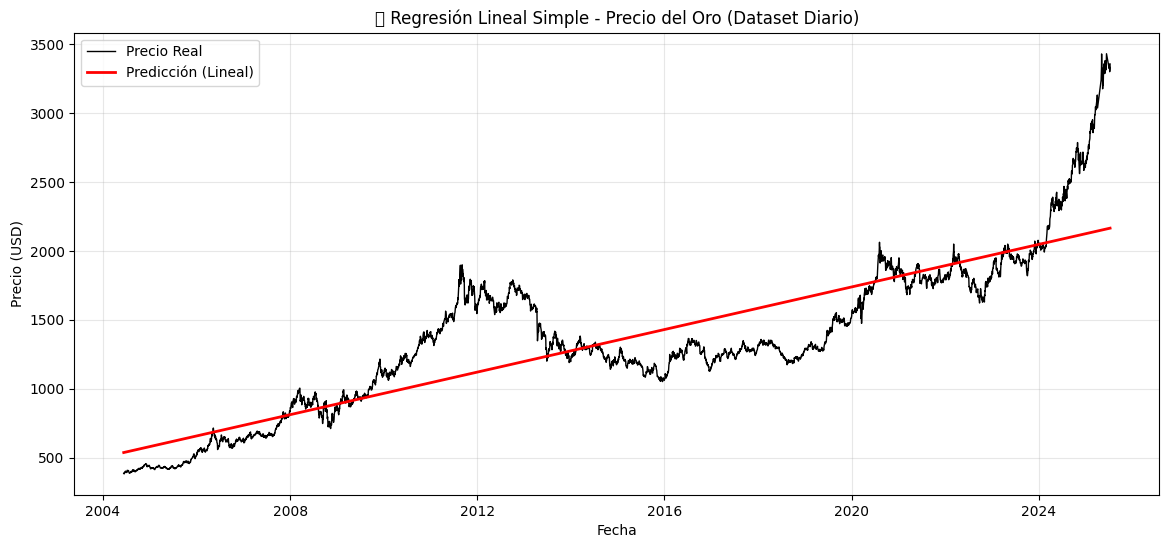

In [57]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], label='Precio Real', color='black', linewidth=1)
plt.plot(df['Date'], df['pred_lin'], label='Predicción (Lineal)', color='red', linewidth=2)
plt.title('📈 Regresión Lineal Simple - Precio del Oro (Dataset Diario)')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

▶ Calcular errores

In [58]:
mae = mean_absolute_error(y, df['pred_lin'])
rmse = np.sqrt(mean_squared_error(y, df['pred_lin']))
r2 = r2_score(y, df['pred_lin'])

print("📊 Resultados de la Regresión Lineal Simple (dataset df)")
print(f"MAE  (Error Absoluto Medio): {mae:.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
print(f"R²   (Coeficiente de Determinación): {r2:.4f}")

📊 Resultados de la Regresión Lineal Simple (dataset df)
MAE  (Error Absoluto Medio): 213.73
RMSE (Raíz del Error Cuadrático Medio): 282.68
R²   (Coeficiente de Determinación): 0.7316


# PREDICCIÓN CON REDES CONVOLUCIONALES

Forma de X: (5352, 30, 1), Forma de y: (5352,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 28, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 12, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0076 - val_loss: 3.6188e-04
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8515e-04 - val_loss: 0.0010
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7044e-04 - val_loss: 3.0722e-04
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3208e-04 - val_loss: 0.0015
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6756e-04 - val_loss: 7.2092e-04
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3585e-04 - val_loss: 6.5323e-04
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1219e-04 - val_loss: 9.3804e-04
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8213e-04 - val_loss: 0.0012
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


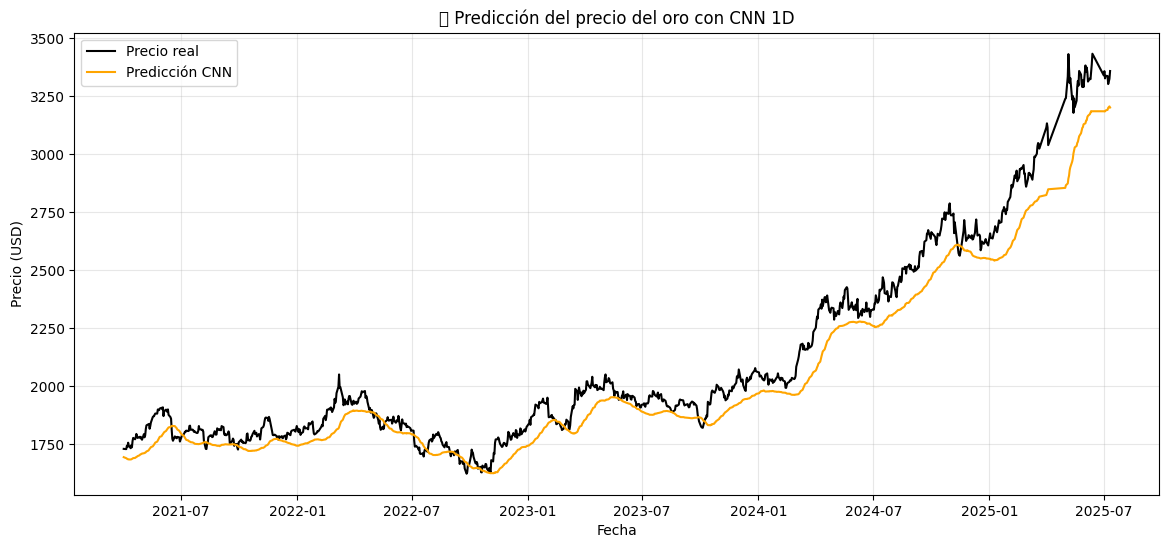

In [63]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(df[['Close']])

# 4️⃣ Crear secuencias de entrenamiento
def create_sequences(data, lookback=30):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

LOOKBACK = 30  # usamos las últimas 30 observaciones (un mes aprox.)
X, y = create_sequences(prices_scaled, LOOKBACK)

# Redimensionar para CNN (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"Forma de X: {X.shape}, Forma de y: {y.shape}")

# 5️⃣ Separar en entrenamiento y prueba (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 6️⃣ Crear modelo CNN
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(LOOKBACK, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# 7️⃣ Entrenar modelo con early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# 8️⃣ Predicciones
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# 9️⃣ Visualización
plt.figure(figsize=(14,6))
plt.plot(df['Date'][-len(y_test):], y_real, label='Precio real', color='black')
plt.plot(df['Date'][-len(y_test):], y_pred, label='Predicción CNN', color='orange')
plt.title('📈 Predicción del precio del oro con CNN 1D')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [64]:
mae = mean_absolute_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
r2 = r2_score(y_real, y_pred)

print("📊 Resultados del modelo CNN")
print(f"MAE  (Error Absoluto Medio): {mae:.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
print(f"R²   (Coeficiente de Determinación): {r2:.4f}")

📊 Resultados del modelo CNN
MAE  (Error Absoluto Medio): 85.66
RMSE (Raíz del Error Cuadrático Medio): 108.11
R²   (Coeficiente de Determinación): 0.9311


▶ PREDICCIÓN CON MÓDELO BÁSICO DE SERIES DE TIEMPO - ARIMA (AutoRegressive Integrated Moving Average)

Es un modelo estadístico lineal, que predice el valor futuro en función de:

Los valores pasados (parte AR),

La diferencia entre valores (parte I, de “integrado”),

Y los errores pasados (parte MA).

In [72]:
# Serie temporal con índice de fechas
series = df.set_index('Date')['Close']
series = series.asfreq('D')  # 🔧 Forzar frecuencia diaria para evitar huecos
series = series.fillna(method='ffill')  # Rellenar si hay días faltantes

# Dividir en entrenamiento y prueba (80/20)
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Entrenar modelo ARIMA
model = ARIMA(train, order=(5,1,2))
model_fit = model.fit()

# Predicción sobre el conjunto de prueba
pred = model_fit.forecast(steps=len(test))
pred.index = test.index  # 🔧 Alinear correctamente índices

# Predicción extendida (90 días al futuro)
future_steps = 90
future_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1),
                             periods=future_steps, freq='D')
future_forecast = model_fit.forecast(steps=future_steps)
future_forecast = pd.Series(future_forecast, index=future_index)

/tmp/ipython-input-3643509516.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method='ffill')  # Rellenar si hay días faltantes


▶ Resultado gráfico de la predicción

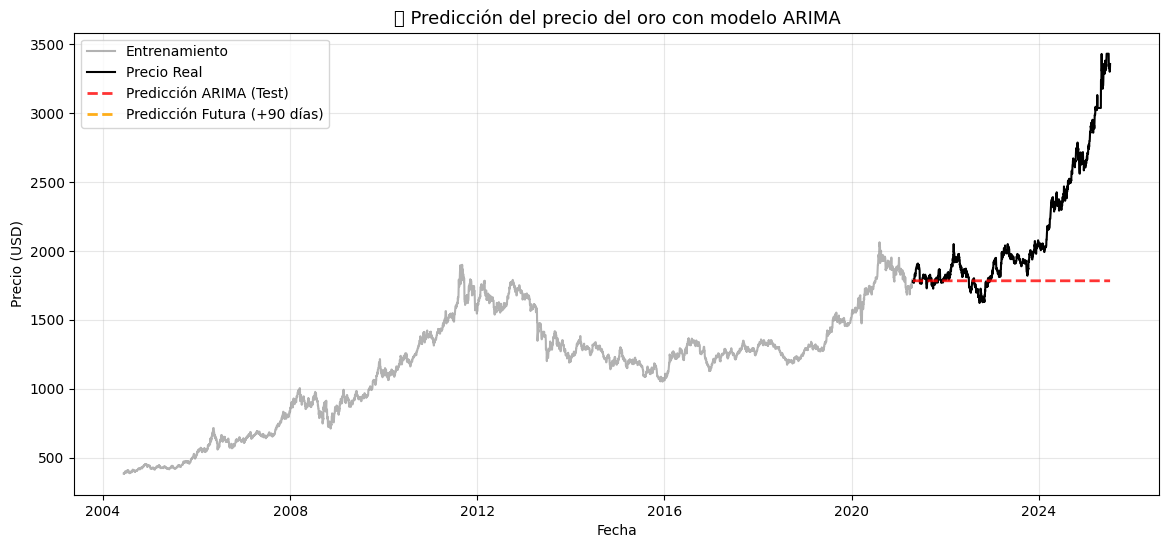

In [76]:
# 📊 Visualización mejorada
plt.figure(figsize=(14,6))
plt.plot(train, color='gray', alpha=0.6, label='Entrenamiento')
plt.plot(test, color='black', linewidth=1.5, label='Precio Real')
plt.plot(pred, color='red', linewidth=2, linestyle='--', alpha=0.8, label='Predicción ARIMA (Test)')
plt.plot(future_forecast, color='orange', linewidth=2, linestyle='--', alpha=0.9, label='Predicción Futura (+90 días)')
plt.title("🔮 Predicción del precio del oro con modelo ARIMA", fontsize=13)
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [74]:
# 5️⃣ Evaluación de métricas
mae = mean_absolute_error(test, pred)
rmse = sqrt(mean_squared_error(test, pred))
r2 = r2_score(test, pred)

print("📊 Resultados del modelo ARIMA")
print(f"MAE  (Error Absoluto Medio): {mae:.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
print(f"R²   (Coeficiente de Determinación): {r2:.4f}")

📊 Resultados del modelo ARIMA
MAE  (Error Absoluto Medio): 365.15
RMSE (Raíz del Error Cuadrático Medio): 566.42
R²   (Coeficiente de Determinación): -0.6166


▶ PREDICCIÓN DE MODELO EN BASE A SERIES DE TIEMPO, ESTACIONALIDAD Y LINEALIDAD - PROPHET

In [86]:
# --- 1️⃣ Preparar dataset base ---
df = df.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# --- 2️⃣ Crear medias móviles (regresores) ---
df['ma_20'] = df['Close'].rolling(window=20).mean()
df['ma_100'] = df['Close'].rolling(window=100).mean()
df['ma_200'] = df['Close'].rolling(window=200).mean()

# Eliminar los primeros NaN generados por las medias
df = df.dropna(subset=['ma_20', 'ma_100', 'ma_200'])

# --- 3️⃣ Preparar datos para Prophet ---
prophet_df = df.rename(columns={'Date': 'ds', 'Close': 'y'})

# --- 4️⃣ Crear y configurar el modelo Prophet ---
model = Prophet(
    changepoint_prior_scale=0.2,   # 🔥 más sensible a cambios
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

# Añadir regresores
for col in ['ma_20', 'ma_100', 'ma_200']:
    model.add_regressor(col)

# --- 5️⃣ Entrenar modelo ---
model.fit(prophet_df)

# --- 6️⃣ Crear futuro (180 días hacia adelante) ---
future = model.make_future_dataframe(periods=180)

# Añadir regresores históricos
future = future.merge(prophet_df[['ds', 'ma_20', 'ma_100', 'ma_200']], on='ds', how='left')

# --- 🔧 7️⃣ Rellenar valores futuros de los regresores con tendencia suave ---
for col in ['ma_20', 'ma_100', 'ma_200']:
    last_val = prophet_df[col].iloc[-1]
    # número de filas a predecir
    n_future = future[col].isna().sum()
    # pequeña tendencia ascendente para evitar líneas planas
    trend_vals = last_val * np.linspace(1, 1.02, n_future)
    # reemplazar los valores NaN por la tendencia
    future.loc[future[col].isna(), col] = trend_vals

# --- 8️⃣ Predicción ---
forecast = model.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0g387bx0/q9nb22em.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0g387bx0/7_gp3nfp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78176', 'data', 'file=/tmp/tmp0g387bx0/q9nb22em.json', 'init=/tmp/tmp0g387bx0/7_gp3nfp.json', 'output', 'file=/tmp/tmp0g387bx0/prophet_model3yset8o2/prophet_model-20251018025335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:53:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:53:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


▶ Gráficas prophet

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


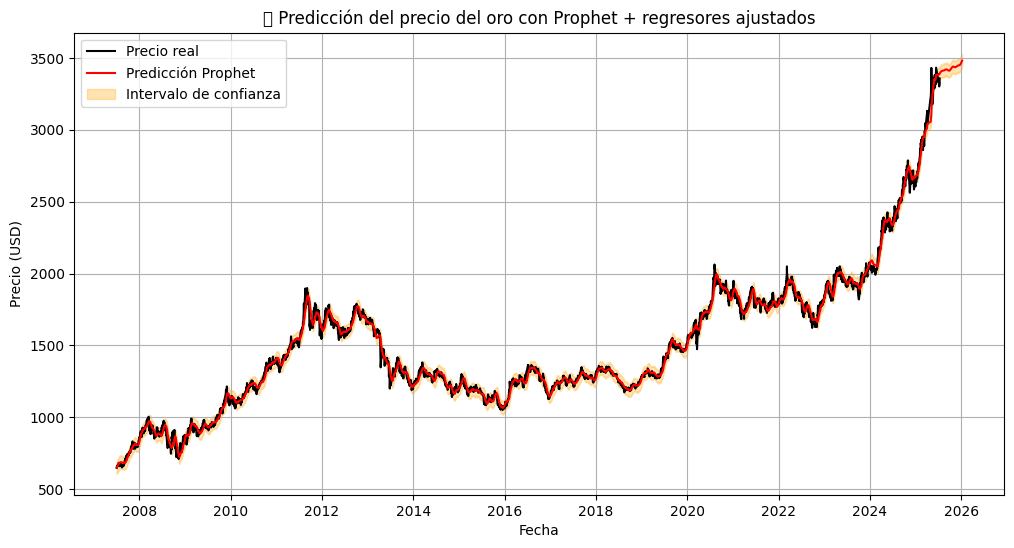

In [87]:
plt.figure(figsize=(12,6))
plt.plot(prophet_df['ds'], prophet_df['y'], color='black', label='Precio real')
plt.plot(forecast['ds'], forecast['yhat'], color='red', label='Predicción Prophet')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='orange', alpha=0.3, label='Intervalo de confianza')
plt.title('📈 Predicción del precio del oro con Prophet + regresores ajustados')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()

▶ Métricas de eficiencia del modelo

In [88]:
# 1️⃣ Filtrar las fechas donde tenemos valores reales
df_eval = prophet_df.merge(forecast[['ds', 'yhat']], on='ds', how='inner')

# 2️⃣ Calcular métricas
mae = mean_absolute_error(df_eval['y'], df_eval['yhat'])
rmse = np.sqrt(mean_squared_error(df_eval['y'], df_eval['yhat']))
r2 = r2_score(df_eval['y'], df_eval['yhat'])

# 3️⃣ Mostrar resultados
print("📊 Evaluación del modelo Prophet")
print(f"MAE  (Error Absoluto Medio): {mae:.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
print(f"R²   (Coeficiente de Determinación): {r2:.4f}")

📊 Evaluación del modelo Prophet
MAE  (Error Absoluto Medio): 25.86
RMSE (Raíz del Error Cuadrático Medio): 35.21
R²   (Coeficiente de Determinación): 0.9942


# MODELO HIBRIDO PROPHET + CNN

In [107]:
# --- 1. Preparar datos para Prophet ---
df_prophet = df[['Date', 'Close']].rename(columns={'Date':'ds', 'Close':'y'})

# --- 2. Entrenar Prophet ---
prophet = Prophet()
prophet.fit(df_prophet)
forecast = prophet.predict(df_prophet)

# --- 3. Preparar datos para CNN ---
y_prophet = forecast['yhat'].values
scaler = MinMaxScaler()
scaled_y = scaler.fit_transform(y_prophet.reshape(-1,1))

def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 30
X, y = create_sequences(scaled_y, seq_len)
X = X.reshape((X.shape[0], X.shape[1], 1))

# --- 4. Construir modelo CNN ---
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(seq_len, 1)),
    MaxPooling1D(2),
    Conv1D(32, 3, activation='relu'),
    Flatten(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=16, verbose=0)

# --- 5. Predicción CNN (residual) ---
pred_scaled = model.predict(X)
pred_cnn = scaler.inverse_transform(pred_scaled)

# --- 6. Predicción futura (90 días) ---
future_steps = 90
last_seq = scaled_y[-seq_len:].reshape(1, seq_len, 1)
future_preds = []

for _ in range(future_steps):
    next_pred = model.predict(last_seq)[0,0]
    future_preds.append(next_pred)
    last_seq = np.append(last_seq[:,1:,:], [[[next_pred]]], axis=1)

# Desescalar la predicción
future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))

# Crear fechas futuras
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(last_date, periods=future_steps+1, freq='D')[1:]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0g387bx0/lrmp1jeq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0g387bx0/p1v7b8lg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54152', 'data', 'file=/tmp/tmp0g387bx0/lrmp1jeq.json', 'init=/tmp/tmp0g387bx0/p1v7b8lg.json', 'output', 'file=/tmp/tmp0g387bx0/prophet_modelphmtc3bn/prophet_model-20251018033901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:39:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:39:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim`

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━

▶ Visualización de modelo hibrido

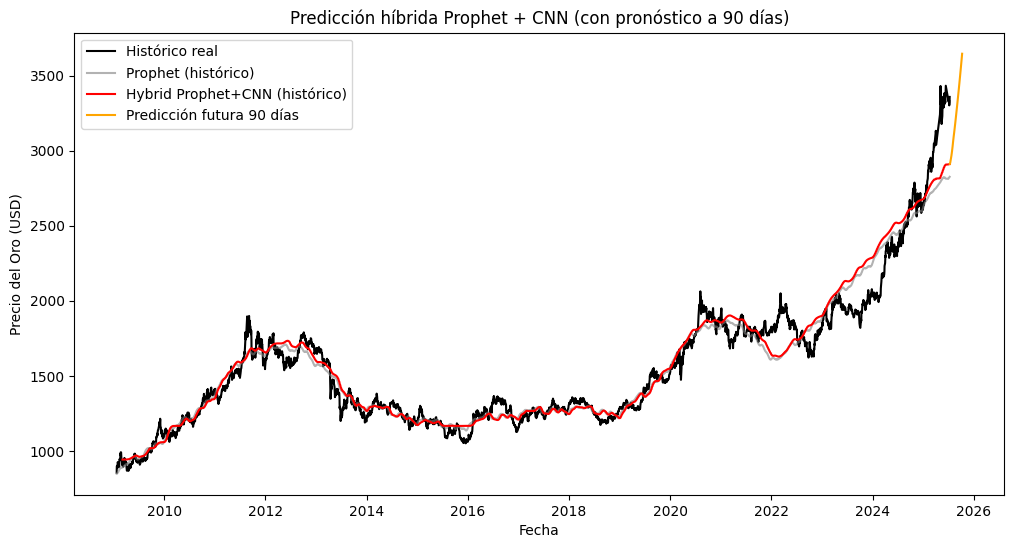

In [108]:
# 📉 9. Visualización completa
# =======================================================
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], color='black', label='Histórico real')
plt.plot(forecast['ds'], forecast['yhat'], color='gray', alpha=0.6, label='Prophet (histórico)')
plt.plot(df['Date'].iloc[-len(pred_cnn):], pred_cnn, color='red', label='Hybrid Prophet+CNN (histórico)')
plt.plot(future_dates, future_preds_inv, color='orange', label='Predicción futura 90 días')
plt.title("Predicción híbrida Prophet + CNN (con pronóstico a 90 días)")
plt.xlabel("Fecha")
plt.ylabel("Precio del Oro (USD)")
plt.legend()
plt.show()

In [110]:
# Alinear tamaños entre valores reales y predichos
y_real = df['Close'].iloc[-len(pred_cnn):]  # últimos valores reales
y_pred = pred_cnn.flatten()                 # predicciones del modelo híbrido

# Calcular métricas
mae = mean_absolute_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
r2 = r2_score(y_real, y_pred)

# Mostrar resultados
print("📊 Validación del Modelo Híbrido Prophet + CNN")
print(f"MAE  (Error Absoluto Medio): {mae:.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
print(f"R²   (Coeficiente de Determinación): {r2:.4f}")

📊 Validación del Modelo Híbrido Prophet + CNN
MAE  (Error Absoluto Medio): 73.55
RMSE (Raíz del Error Cuadrático Medio): 108.23
R²   (Coeficiente de Determinación): 0.9372
